In [1]:
import numpy as np
import sys
# option to import from github folder
#sys.path.insert(0, '/media/carsen/DATA2/Github/suite2p')
sys.path.insert(0, 'C:/Users/carse/github/suite2p')

import imp
from suite2p import run_s2p
from suite2p import utils
from skimage.external.tifffile import imread
from ScanImageTiffReader import ScanImageTiffReader

tif = ScanImageTiffReader('D:/DATA/BOT/BOT_VxAC031419M1_noiseburst-001_Cycle00001_Ch1_000001.ome.tif')
im = tif.data()

<class 'numpy.uint16'>


8191

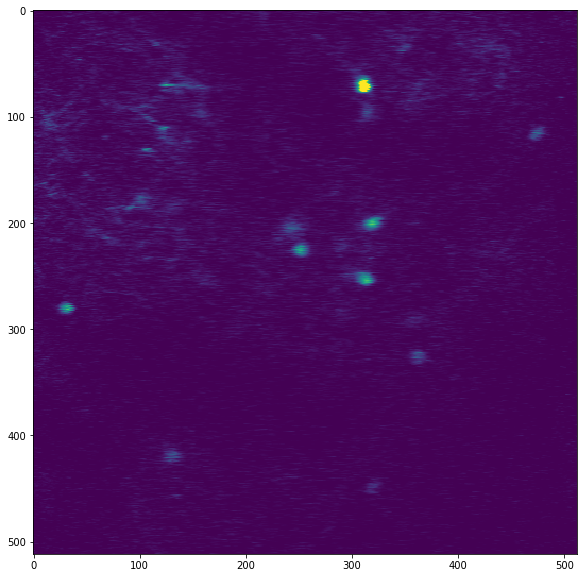

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,10))
plt.imshow(im)
print(type(im[0,0]))
im.max()

In [59]:
import gc
import time
from suite2p.utils import init_ops, find_files_open_binaries
def tic():
    return time.time()
def toc(i0):
    return time.time() - i0

def ome_to_binary(ops):
    '''
    converts ome.tiff to *.bin file for non-interleaved red channel recordings
    assumes single-page tiffs
    also assumes only single-plane recordings - will fail otherwise
    requires ops keys: nplanes, nchannels, data_path, look_one_level_down, reg_file
    assigns ops keys: tiffreader, first_tiffs, frames_per_folder, nframes, meanImg, meanImg_chan2

    '''
    t0=tic()
    # copy ops to list where each element is ops for each plane
    ops1 = init_ops(ops)
    nplanes = ops1[0]['nplanes']

    # open all binary files for writing
    # look for tiffs in all requested folders
    ops1, fs, reg_file, reg_file_chan2 = find_files_open_binaries(ops1, False)
    ops = ops1[0]
    
    fs_Ch1, fs_Ch2 = [], []
    for f in fs:
        if f.find('Ch1')>-1:
            if ops['functional_chan'] == 1:
                fs_Ch1.append(f)
            else:
                fs_Ch2.append(f)
        else:
            if ops['functional_chan'] == 1:
                fs_Ch2.append(f)
            else:
                fs_Ch1.append(f)
        
    if len(fs_Ch2)==0:
        ops1[0]['nchannels'] = 1
    nchannels = ops1[0]['nchannels']
        
    # loop over all tiffs
    which_folder = 0
    ntotal=0
    tif = ScanImageTiffReader(fs_Ch1[0])
    im0 = tif.data()
    Ly,Lx = im0.shape
    j=0
    nframes = len(fs_Ch1)
    ops1[j]['nframes'] = nframes
    ops1[j]['frames_per_folder'][0] = nframes
    ops1[j]['meanImg'] = np.zeros((Ly,Lx))
    ix=0
    for ik, file in enumerate(fs_Ch1):
        # open tiff
        tif = ScanImageTiffReader(file)
        im = tif.data()
        if type(im[0,0]) == np.uint16:
            im = im // 2
            im = im.astype(np.int16)
        if ik==0:
            ops['meanImg'] += im
                                    
        reg_file[j].write(bytearray(im))
        ix+=1
        if ix%(1000)==0:
            print('%d frames of binary, time %0.2f sec.'%(ntotal,toc(t0)))
        gc.collect()
                                    
    if nchannels>1:
        ops1[j]['meanImg_chan2'] = np.zeros((Ly,Lx))   
        ix=0
        for ik, file in enumerate(fs_Ch2):
            # open tiff
            tif = ScanImageTiffReader(file)
            im = tif.data()
            
            if type(im[0,0]) == np.uint16:
                im = im // 2
                im = im.astype(np.int16)
                
            if ik==0:
                ops['meanImg_chan2'] += im

            reg_file_chan2[j].write(bytearray(im))
            ix+=1
            if ix%(1000)==0:
                print('%d frames of binary, time %0.2f sec.'%(ntotal,toc(t0)))
            gc.collect()

                                    
    # write ops files
    do_registration = ops['do_registration']
    do_nonrigid = ops1[0]['nonrigid']
    for ops in ops1:
        ops['Ly'],ops['Lx'] = Ly,Lx
        if not do_registration:
            ops['yrange'] = np.array([0,ops['Ly']])
            ops['xrange'] = np.array([0,ops['Lx']])
        ops['meanImg'] /= ops['nframes']
        if nchannels>1:
            ops['meanImg_chan2'] /= ops['nframes']
        np.save(ops['ops_path'], ops)
    # close all binary files and write ops files
    for j in range(0,nplanes):
        reg_file[j].close()
        if nchannels>1:
            reg_file_chan2[j].close()
    return ops1

from suite2p import run_s2p

ops=run_s2p.default_ops()
ops['data_path'] = ['D:/DATA/BOT/']
ops['save_path0'] = ops['data_path'][0]
ops['save_folder'] = []
ops['subfolders'] = []
ops['nplanes'] = 1
ops['nchannels'] = 2
ops['look_one_level_down'] = False
ops['regfile'] = 'D:/DATA/BOT/suite2p/plane0/data.bin'
ops['regfile_chan2'] = 'D:/DATA/BOT/suite2p/plane0/data_chan2.bin'

ops1=ome_to_binary(ops)

np.save('D:/DATA/BOT/suite2p/plane0/ops.npy', ops1[0])

** Found 10 tifs - converting to binary **


In [52]:
[f.find('Ch1')>-1 for f in fs[0]]

[True, True, True, True, True, False, False, False, False, False]

In [35]:
from suite2p.utils import get_tif_list, list_tifs
ops1=init_ops(ops)
fs = get_tif_list(ops)
#ops1, fs, reg_file, reg_file_chan2 = find_files_open_binaries(ops1, False)

fs[0][0].find('Ch1')>-1

** Found 10 tifs - converting to binary **


55

In [15]:
import glob,os

glob.glob(os.path.join(ops['data_path'], '*.tif'))

['D:/DATA/BOT\\BOT_VxAC031419M1_noiseburst-001_Cycle00001_Ch1_000001.ome.tif',
 'D:/DATA/BOT\\BOT_VxAC031419M1_noiseburst-001_Cycle00001_Ch1_000002.ome.tif',
 'D:/DATA/BOT\\BOT_VxAC031419M1_noiseburst-001_Cycle00001_Ch1_000003.ome.tif',
 'D:/DATA/BOT\\BOT_VxAC031419M1_noiseburst-001_Cycle00001_Ch1_000004.ome.tif',
 'D:/DATA/BOT\\BOT_VxAC031419M1_noiseburst-001_Cycle00001_Ch1_000005.ome.tif',
 'D:/DATA/BOT\\BOT_VxAC031419M1_noiseburst-001_Cycle00001_Ch2_000001.ome.tif',
 'D:/DATA/BOT\\BOT_VxAC031419M1_noiseburst-001_Cycle00001_Ch2_000002.ome.tif',
 'D:/DATA/BOT\\BOT_VxAC031419M1_noiseburst-001_Cycle00001_Ch2_000003.ome.tif',
 'D:/DATA/BOT\\BOT_VxAC031419M1_noiseburst-001_Cycle00001_Ch2_000004.ome.tif',
 'D:/DATA/BOT\\BOT_VxAC031419M1_noiseburst-001_Cycle00001_Ch2_000005.ome.tif']

In [2]:
print(ops['data_path'])
# copy ops to list where each element is ops for each plane
# load json file with line start stops
if 'lines' not in ops:
    fpath = os.path.join(ops['data_path'][0], '*json')
    fs = glob.glob(fpath)
    with open(fs[0], 'r') as f:
        opsj = json.load(f)
    ops['nplanes'] = len(opsj)
else:
    ops['nplanes'] = len(ops['lines'])
ops1 = init_ops(ops)
ops = ops1[0]

if 'lines' not in ops:
    for j in range(len(ops1)):
        ops1[j] = {**ops1[j], **opsj[j]}.copy()

# open all binary files for writing
# look for tiffs in all requested folders
ops1, fs, reg_file, reg_file_chan2 = find_files_open_binaries(ops1, False)

nplanes = ops1[0]['nplanes']
nchannels = ops1[0]['nchannels']
if nchannels>1:
    nfunc = ops['functional_chan']-1
else:
    nfunc = 0
batch_size = ops['batch_size']

# which tiff reader works for user's tiffs
sktiff = choose_tiff_reader(fs[0], ops1[0])

# loop over all tiffs
which_folder = -1
for ik, file in enumerate(fs):
    # open tiff
    tif, Ltif = open_tiff(file, sktiff)
    if ops['first_tiffs'][ik]:
        which_folder += 1
    ix = 0
    while 1:
        if ix >= Ltif:
            break
        nfr = min(Ltif - ix, batch_size)
        if sktiff:
            im = imread(file, pages = range(ix, ix + nfr), fastij = False)
        else:
            if Ltif==1:
                im = tif.data()
            else:
                im = tif.data(beg=ix, end=ix+nfr)
        if im.size==0:
            break
        #im = io.imread(file)
        if len(im.shape)<3:
            im = np.expand_dims(im, axis=0)
        nframes = im.shape[0]
        for j in range(0,nplanes):
            if ik==0:
                ops1[j]['meanImg'] = np.zeros((len(ops1[j]['lines']),im.shape[2]),np.float32)
                if nchannels>1:
                    ops1[j]['meanImg_chan2'] = np.zeros((len(ops1[j]['lines']),im.shape[2]),np.float32)
                ops1[j]['nframes'] = 0
            imj = im[:,ops1[j]['lines'],:].astype(np.int16)
            i0 = nchannels
            if nchannels>1:
                nfunc = ops['functional_chan'] - 1
            else:
                nfunc = 0
            im2write = imj[np.arange(int(i0)+nfunc, nframes, nchannels, int), :, :]
            ops1[j]['meanImg'] += im2write.astype(np.float32).sum(axis=0)
            reg_file[j].write(bytearray(im2write))
            if nchannels>1:
                im2write = imj[np.arange(int(i0)+1-nfunc, nframes, nchannels, int), :, :]
                reg_file_chan2[j].write(bytearray(im2write))
                ops1[j]['meanImg_chan2'] += im2write.astype(np.float32).sum(axis=0)
            ops1[j]['nframes'] += im2write.shape[0]
            ops1[j]['frames_per_folder'][which_folder] += im2write.shape[0]
        ix+=nframes

In [6]:
im.shape

(100, 768, 768)

In [ ]:
data = imread(fs[0])
#im=tif.data()
print(data.shape)

In [ ]:
data = data / 2

In [ ]:
import matplotlib.pyplot as plt
from suite2p import register, nonrigid, utils
import imp
imp.reload(register)
imp.reload(nonrigid)

ops['Ly'] = data.shape[1]
ops['Lx'] = data.shape[2]

#refImg=register.pick_init_init(ops, data[::4,:,:])
#refImg =register.refine_init_init(ops, data[::4,:,:], refImg)
#plt.imshow(refImg)
#plt.show()
print('mean img')

dwrite = data[:200,:,:].copy()

#for j in range(2):
#    if j>0:
#        refImg=register.pick_init_init(ops, dwrite[:,:,:])
#        refImg =register.refine_init_init(ops, dwrite[:,:,:], refImg)
#        print('mean img')
    
maskMul, maskOffset, cfRefImg = register.prepare_masks(refImg.copy(), ops)
if ops['nonrigid']:
    ops = utils.make_blocks(ops)
    maskMulNR, maskOffsetNR, cfRefImgNR = nonrigid.prepare_masks(refImg, ops)
    refAndMasks = [maskMul, maskOffset, cfRefImg, maskMulNR, maskOffsetNR, cfRefImgNR]
else:
    refAndMasks = [maskMul, maskOffset, cfRefImg]
dwrite, ymax, xmax, cmax, yxnr = register.phasecorr(dwrite, refAndMasks, ops)
print('registered')

    

In [ ]:
type(data[0,0,0])

In [ ]:
plt.imshow(dwrite.mean(axis=0))

In [ ]:
maskMul, maskOffset, cfRefImg = register.prepare_masks(refImg.copy(), ops)
plt.imshow(np.real(np.fft.ifft2(np.conj(cfRefImg[0,:,:]))))

In [ ]:
imp.reload(register)



plt.figure(figsize=(10,10))
plt.imshow(np.real(fft.ifft2(np.conj(cfRefImg))))
#plt.imshow(fhg)

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(refImg)

In [ ]:
plt.imshow(data[1,:,:])

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(ymax[:])
plt.plot(xmax[:])
plt.show()

In [ ]:
plt.plot(yxnr[0][-1,:])
plt.show()
yxnr[0].shape

In [ ]:
import numpy as np

from matplotlib import animation, rc
from IPython.display import HTML
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots(figsize=(10,10))

#dwrite = data

#line, = ax.plot([], [], lw=2)
im = ax.imshow(dwrite[0,:,:],cmap='gray')

# initialization function: plot the background of each frame
def init():
    im.set_data(dwrite[0,:,:])#,cmap='gray')
    return (im,)
# animation function. This is called sequentially
def animate(i):
    im.set_data(dwrite[i,:,:])#,cmap='gray')
    return (im,)
# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=100, blit=True)
HTML(anim.to_html5_video())

In [ ]:
dwrite.max()

In [ ]:
2**15

In [ ]:
plt.figure(figsize=(20,10))
ix=186
vm=-40
vx=40
plt.subplot(1,2,1)
plt.imshow(data[ix,:,:]-data[ix+1,:,:],vmin=vm,vmax=vx)
plt.subplot(1,2,2)
plt.imshow(dout[ix,:,:]-dout[ix+1,:,:],vmin=vm,vmax=vx)

In [ ]:
dout=data

In [ ]:
from skimage.external.tifffile import TiffFile

#fs = ['/home/carsen/TIFFS/TSeries-20170508-D43-001_Cycle00001_Ch2_000001.ome.tif']
fs = ['/home/carsen/TIFFS/MP032/2017-08-01_6_M170714_MP032_2P_001_001.tif'];

import time

tic = time.time()
tif = TiffFile(fs[0])
print(time.time()-tic)

print(tif[0].asarray())

In [ ]:
1800/12 * 5

In [ ]:
F = np.load('/home/carsen/Downloads/suite2p/plane0/F.npy')
F.shape

In [ ]:
import scipy.io

Fall = scipy.io.loadmat('/home/carsen/Downloads/suite2p/plane0/Fall.mat',squeeze_me=True)

In [ ]:
Fall['F'].shape